> Aprenentatge Computacional

**Nom**: Gabriel Rios Sanchez\
**NIU**: 1671177

# SUPERMARKET SALES

---

In [33]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score

# LLIBRERIA PER DIVIDIR EL CONJUNT D'ENTRENAMENT I PROVA
from sklearn.model_selection import train_test_split

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

import warnings
warnings.filterwarnings('ignore')

## 0. ENUNCIAT INICIAL

L’objectiu és predir la sucursal (Branch) on es realitzen les vendes per optimitzar la gestió dels inventaris en cada ubicació. Per aconseguir-ho, es desenvoluparan diferents models de predicció que permetin estimar la variable objectiu amb la màxima precisió possible.

In [34]:
dataset = pd.read_csv("dataset/data.csv")
dataset.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


---

## 1. ANÀLISI DE DADES

In [35]:
print("El dataset conté:", dataset.shape[0], "mostres i", dataset.shape[1], "atributs.")

El dataset conté: 1000 mostres i 17 atributs.


Per començar, s’executarà la funció `identifyCategoricalFeatures` per identificar les variables categòriques de manera ràpida. Aquesta funció analitza la proporció de valors únics d’un atribut i, en funció d’un llindar definit com a paràmetre d’entrada, decideix si un atribut numèric s’ha de considerar categòric o no. Posteriorment, es descriurà el significat de cada atribut i s’analitzarà la distribució dels seus valors.

In [36]:
def identifyCategoricalFeatures(data, threshold=0.05):
    categoricalCols = data.select_dtypes(include='object').columns.tolist()
    numericalCols = data.select_dtypes(include='number')
    uniqueProp = numericalCols.nunique() / len(data)
    categoricalCols += uniqueProp[uniqueProp < threshold].index.tolist()
    return categoricalCols

atributsCategoricsIdentify = identifyCategoricalFeatures(dataset)
print("Atributs categòrics: ", atributsCategoricsIdentify)

Atributs categòrics:  ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment', 'Quantity', 'gross margin percentage']


In [37]:
descripcio = pd.DataFrame({
    "|Nom de la columna|": dataset.columns,
    "|Tipus de dades reals|": ["Categòric" if str(dtype) == "object" else "Numèric" for dtype in dataset.dtypes],
    "|Tipus de dades trobades|": ["Categòric" if col in atributsCategoricsIdentify else "Numèric" for col in dataset.columns]
})
print(descripcio)

        |Nom de la columna| |Tipus de dades reals| |Tipus de dades trobades|
0                Invoice ID              Categòric                 Categòric
1                    Branch              Categòric                 Categòric
2                      City              Categòric                 Categòric
3             Customer type              Categòric                 Categòric
4                    Gender              Categòric                 Categòric
5              Product line              Categòric                 Categòric
6                Unit price                Numèric                   Numèric
7                  Quantity                Numèric                 Categòric
8                    Tax 5%                Numèric                   Numèric
9                     Total                Numèric                   Numèric
10                     Date              Categòric                 Categòric
11                     Time              Categòric                 Categòric

A la anterior taula podem veure informació sobre cada atribut. La primera columna es el nom, la segona es el seu tipus de dades reals, es a dir, si al dataset es numeric o no. En canvi, a la tercera columna es mostren els resultats que ha tret la funció `identifyCategoricalFeatures`. Aquesta última columna ens permet identificar si un atribut numèric és en realitat categòric. Això és important d’identificar correctament, ja que afecta directament com es processen i s’analitzen les dades.

Com a resultat d'analitzar la taula, veiem que la funció `identifyCategoricalFeatures` ha identificat dos atributs numèrics com a categòrics. Aquest atributs son: **Quantity** i **gross margin percentage**. Després de la descripció, analitzarem la naturalesa d’aquestes dades per entendre per què la funció les ha identificat com a categòriques.

A continuació, es farà una descripció de cada atribut per analitzar el significat de cadascun.
- **Invoice ID (categòric)**: Identificador únic per a cada transacció realitzada al supermercat. No es tindrà en compte, ja que és únic per cada mostra.
- **Branch (categòric)**: Atribut objectiu que representa la sucursal de supermercat on s’ha efectuat la venda (A, B o C).
- **City (categòric)**: La ciutat on es troba la sucursal associada a la venda. (Yangon, Naypyitaw o Mandalay).
- **Customer type (categòric)**: Indica si el client és un membre o no del supermercat (Member o Normal).
- **Gender (categòric)**: Gènere del client que ha realitzat la compra (Male o Female).
- **Product line (categòric)**: La categoria del producte comprat (Health and Beauty, Electronic Accessories, Home and lifestyle, Sports and travel, Food and beverages o Fashion accessories).
- **Unit price (numèric)**: Preu unitari del producte comprat.
- **Quantity (numèric)**: Quantitat de productes comprats en una sola transacció.
- **Tax 5% (numèric)**: Import corresponent a l’impost aplicat (5%) sobre la transacció.
- **Total (numèric)**: Import total de la factura, incloent-hi l’impost (Tax 5%).
- **Date (categòric)**: Data en què es va realitzar la transacció.
- **Time (categòric)**: Hora en què es va fer la transacció.
- **Payment (categòric)**: Mètode de pagament utilitzat pel client (Ewallet, Cash o Credit Card).
- **cogs (numèric)**: Representa el cost dels productes venuts, abans d’impostos o beneficis.
- **gross margin percentage (numèric)**: Percentatge de marge brut.
- **gross income (numèric)**: Benefici brut obtingut per la venda.
- **Rating (numèric)**: Valoració del client sobre el servei del supermercat, en una escala de 0 a 10.

Com s’ha comentat abans, es farà un anàlisi més a fons de cada atribut. Primer començarem amb els atributs numèrics, ja que sovint tenen una major influència en les prediccions dels models, especialment en aquells que treballen amb valors continus. Ens centrarem especialment en els atributs **Quantity** i **gross margin percentage**, ja que la funció anterior els ha identificat com a categòrics.

A continuació, es mostren les estadístiques bàsiques dels atributs numèrics del dataset mitjançant la funció describe. Aquest resum inclou la mitjana (mean), la desviació estàndard (std), i els valors mínims i màxims, entre d’altres.

Després d’aquest anàlisi, continuarem amb els atributs categòrics, fent un anàlisi de la seva distribució i interpretació.

In [38]:
dataset.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


Podem veure a la taula anterior que els camps com **Unit price**, **Total** i **cogs** tenen una alta variació, cosa que pot ser útil per explicar patrons en les dades. En canvi, **gross margin percentage** és constant i no aportarà informació útil als models. Aquest va ser el motiu pel qual la funció va detectar aquest atribut com a categòric, per tant, al no aportar informació s'eliminarà de tot el conjunt de dades.

En quant a l'atribut **Quantity**, podem veure que té un comportament categòric, com ja va detectar la funció `identifyCategoricalFeatures`, ja que conté un rang limitat de valors únics.

A més, gràcies a aquesta taula, podem identificar si algun atribut conté *outliers*, cosa que en aquest cas no passa ja que les seves desviacions estan dins del rang esperat. Les estadístiques també mostren que les distribucions dels atributs són relativament equilibrades, sense biaix cap a valors extrems. Això valida la coherència de les dades, especialment en atributs com **Total**, **Tax 5%**, **cogs** i **gross income**, que segons la descripció anterior tenen una alta relació entre ells.

A continuació, es veurà la matriu de correlacions de les variables numèriques per identificar la relació entre elles, i així poder entendre millor com interactuen les diferents variables i com poden influir en els resultats de la predicció dels models.

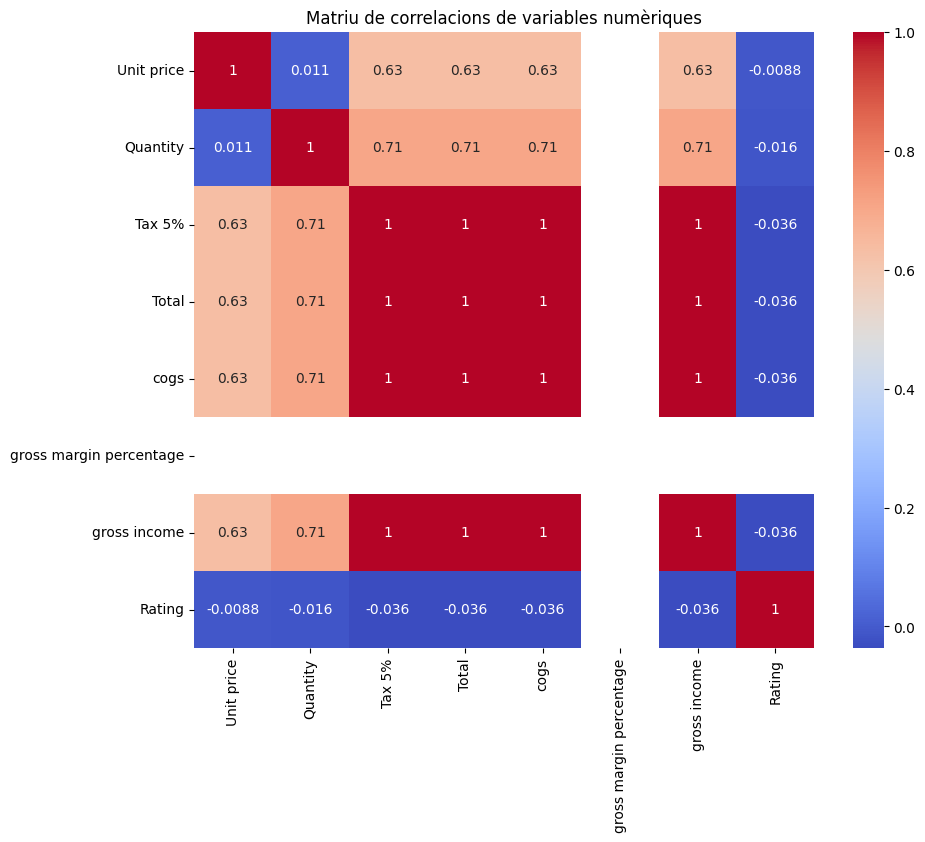

In [47]:
atributsNumerics = dataset.select_dtypes(["float64", "int64"])
correlacioNumerics = atributsNumerics.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacioNumerics, annot=True, cmap='coolwarm')
plt.title("Matriu de correlacions de variables numèriques")
plt.show()

Com ja s’ha comentat abans, podem observar que l’atribut **gross margin percentage** no té cap influència sobre cap altre atribut del conjunt de dades. A més, es confirma que els atributs **Tax 5%**, **Total**, **cogs** i **gross income** estan directament relacionades (1), ja que segueixen una relació lògica a la seva descripció. Aquestes observacions es tindran en compte durant la selecció d’atributs per al model que es construirà.

Per concluir l'anàlisi numèric compararem la correlació que tenen aquests atributs amb la variable objectiu (target) **Branch**. En aquest cas, com el target no és numèric, es farà un encoding simple per poder fer l'anàlisi de correlació.

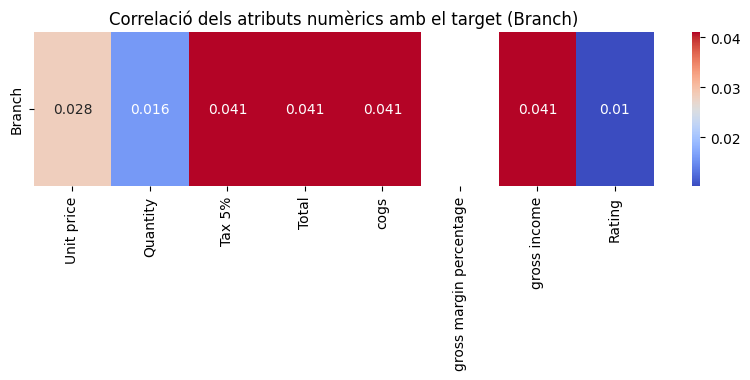

In [50]:
atributsNumerics["Branch"] = dataset["Branch"].astype("category").cat.codes
correlacioNumericsTarget = atributsNumerics.corr().loc["Branch"].drop("Branch").to_frame()
plt.figure(figsize=(10, 2))
sns.heatmap(correlacioNumericsTarget.T, annot=True, cmap="coolwarm")
plt.title("Correlació dels atributs numèrics amb el target (Branch)")
plt.show()

En aquesta secció, s'analitza la distribució de les variables categòriques presents al dataset. Aquest tipus d'anàlisi és essencial per comprendre la composició de les dades i identificar possibles desequilibris que podrien influir en els resultats finals. Les variables categòriques seleccionades són: **Branch**, **City**, **Customer type**, **Gender**, **Product line** i **Payment**. S'ha excluit els atributs **Date** i **Time**, ja que posteriorment es farà un anàlisi temporal d'aquests atributs.


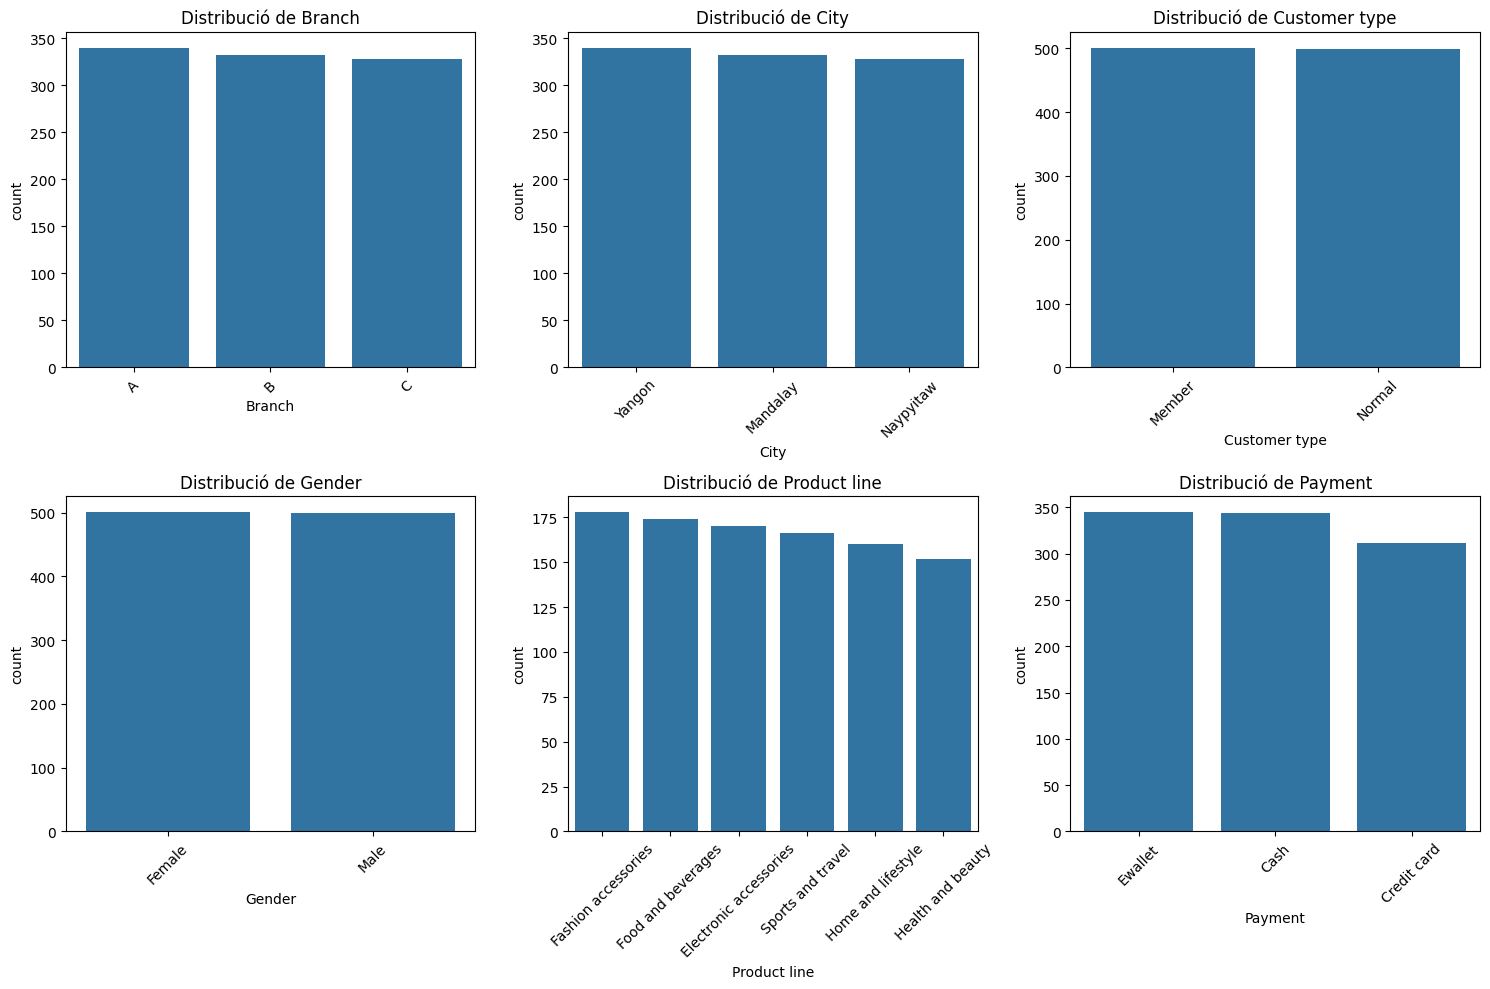

In [41]:
atributsCategorics = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(atributsCategorics):
    sns.countplot(data=dataset, x=col, order=dataset[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribució de {col}")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

A continuació, es mostrarà en una matriu si hi han valors faltants (nuls) al dataset, per posteriorment fer un tractament, si n'hi ha, al preprocessat de dades.

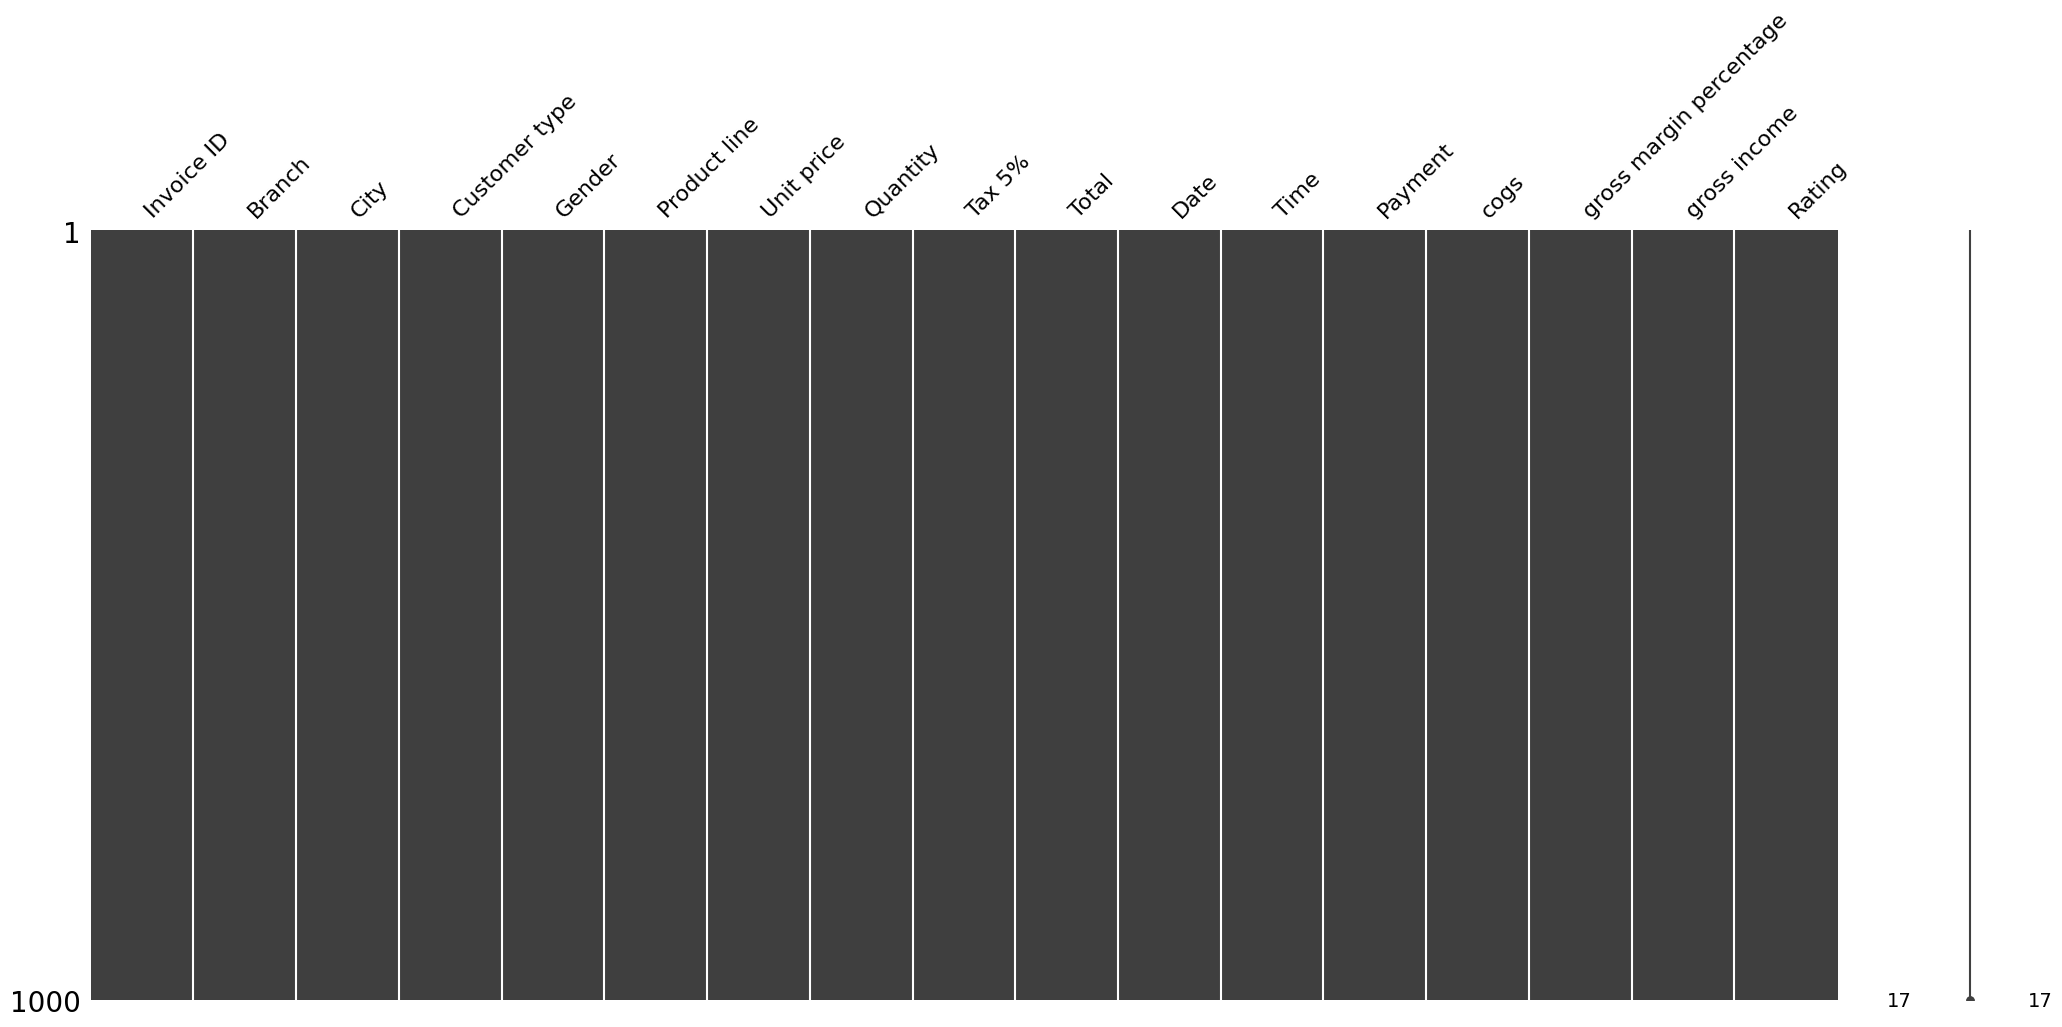

In [42]:
msno.matrix(dataset)
plt.show()

Com a resultat, es confirma que no hi ha valors nuls en cap columna del dataset. Això indica que no cal fer un tractament de valors faltants al preprocessat.

In [43]:
dataset['gross margin percentage'].unique()

array([4.76190476])

---

## 2. PREPROCESSAT

---

## 3. SELECCIÓ DE MODELS

---

## 4. CONCLUSIÓ